In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import obspy
from datetime import datetime
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing

# def import_data(day, starttime, endtime):
# def import_data(day):
#     daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
#     data = load.import_corrected_data_for_single_day(daypaths)
#     # data.trim(starttime=starttime, endtime=endtime)
#     return data

plt.rcParams.update({'font.size': 15})


In [2]:
# ba1d_otherpt = pd.read_excel('~/data/timeseries/BA1D_p_T_2019_2020_1.xlsx')
# ba1d_otherpt.head()

In [3]:
# import p[ressure data
ba1d_otherpt = pd.read_excel('~/data/timeseries/BA1D_p_T_2019_2020_1.xlsx')
ba1d_otherpt.columns = [c.strip() for c in ba1d_otherpt.columns]
ba1d_otherpt['Date and Time'] = pd.to_datetime(ba1d_otherpt['Date and Time'])

# import breakouts data
df141 = pd.read_csv('/home/mnky9800n/data/timeseries/141precision.csv')
df188 = pd.read_csv('/home/mnky9800n/data/timeseries/188precision.csv')
df197 = pd.read_csv('/home/mnky9800n/data/timeseries/197precision.csv')
df211 = pd.read_csv('/home/mnky9800n/data/timeseries/211precision.csv')

ba1a_breakouts = pd.concat([df141, df188, df197, df211])
ba1a_breakouts['ot_dt'] = ba1a_breakouts.origin_time.apply(lambda t: pd.to_datetime(obspy.UTCDateTime(t).datetime))
ba1a_breakouts = ba1a_breakouts.groupby(['depth', pd.Grouper(key='ot_dt', freq='1min')]).count().reset_index()[['ot_dt', 'id']]
ba1a_breakouts.sort_values(by='ot_dt', inplace=True)
ba1a_breakouts['cumulative_events'] = ba1a_breakouts['id'].cumsum()
ba1a_breakouts.reset_index(inplace=True)

ba1a_breakouts_start = ba1d_otherpt.iloc[0]['Date and Time']
ba1a_breakouts_end = ba1d_otherpt.iloc[-1]['Date and Time']

ba1a_t = [np.datetime64(pd.to_datetime('05-01-2019')),] +  list(ba1a_breakouts['ot_dt'].values) + [np.datetime64(ba1a_breakouts_end),]
ba1a_y = [0,] + list(ba1a_breakouts['cumulative_events'].values) + [ba1a_breakouts.cumulative_events.max(),]

# import precip data
precipitation = pd.read_csv('/home/mnky9800n/data/timeseries/daily_precipitation.csv')
precipitation.columns = ['datetime', 'total_precip']
precipitation['datetime'] = pd.to_datetime(precipitation['datetime'])
precipitation

,datetime,total_precip
0,2019-01-01,0.0
1,2019-01-02,0.0
2,2019-01-03,0.0
3,2019-01-04,0.0
4,2019-01-05,0.0
...,...,...
420,2020-02-25,0.0
421,2020-02-26,0.0
422,2020-02-27,0.0
423,2020-02-28,0.0


In [4]:
ba1d_otherpt[ba1d_otherpt['Date and Time'].between(pd.to_datetime('05-21-2019'), pd.to_datetime('05-22-2019'))]

,Date and Time,Seconds,Pressure (Bar),Temperature (C)
11738,2019-05-21 00:06:00,10587063.41,1.756,34.627
11739,2019-05-21 00:21:00,10587963.41,1.756,34.580
11740,2019-05-21 00:36:00,10588863.41,1.756,34.580
11741,2019-05-21 00:51:00,10589763.41,1.757,34.627
11742,2019-05-21 01:06:00,10590663.41,1.758,34.627
...,...,...,...,...
11829,2019-05-21 22:51:00,10668963.41,1.814,34.580
11830,2019-05-21 23:06:00,10669863.41,1.815,34.532
11831,2019-05-21 23:21:00,10670763.41,1.815,34.580
11832,2019-05-21 23:36:00,10671663.41,1.815,34.580


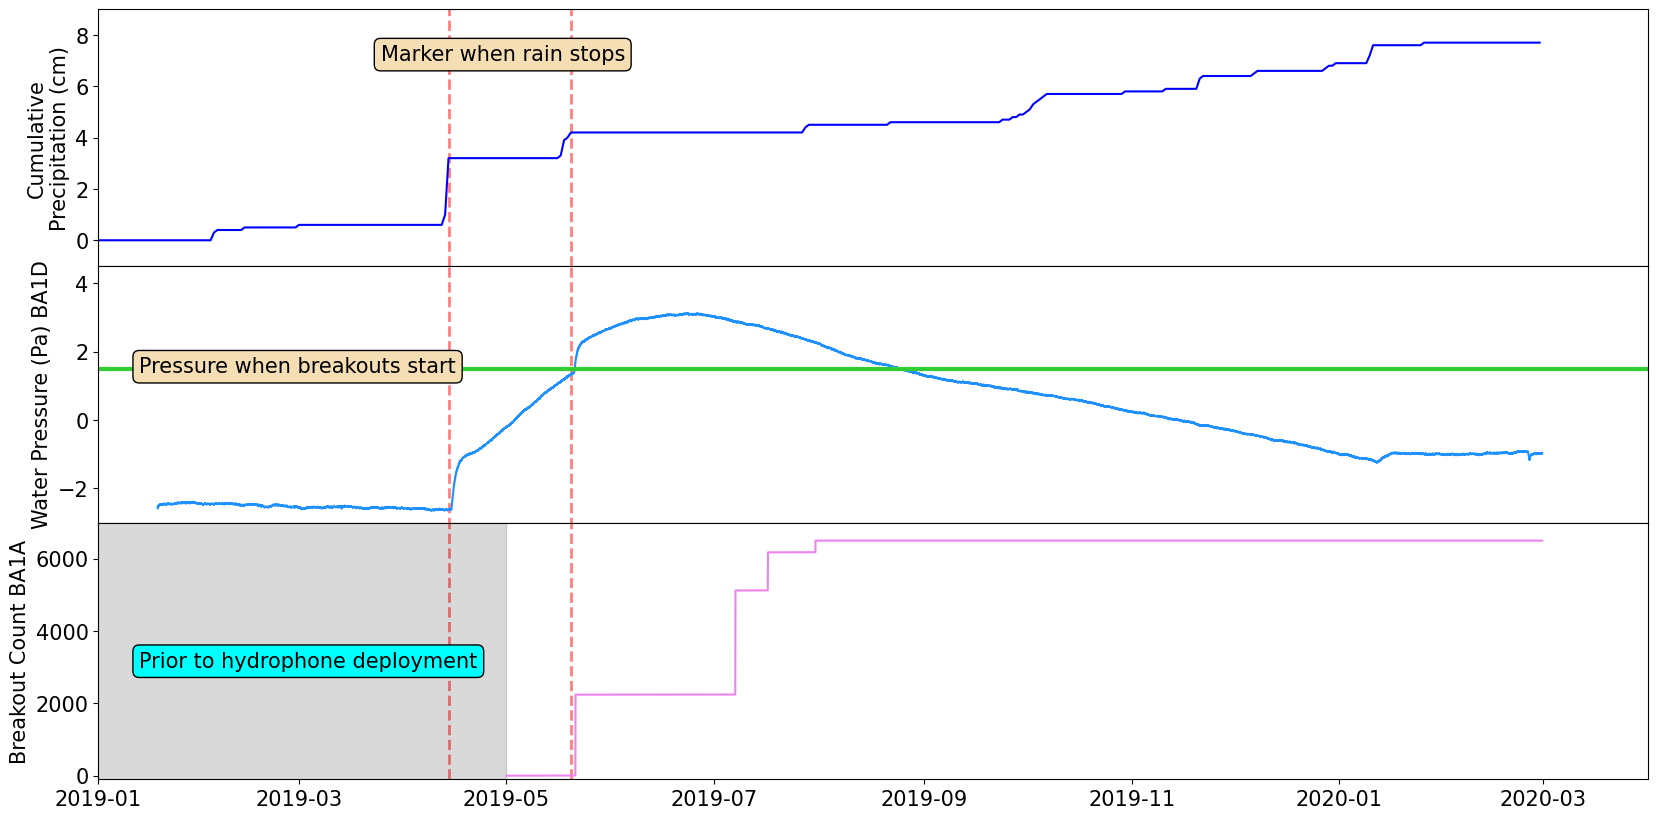

In [5]:
# %matplotlib widget
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

ax[0].set_ylabel('Cumulative\nPrecipitation (cm)')
ax[1].set_ylabel('Water Pressure (Pa) BA1D')
ax[2].set_ylabel('Breakout Count BA1A')

ax[0].set_ylim(-1, 9)
# ax[1].set_ylim(1.3e5, 2.0e5)
ax[1].set_ylim(-3, 4.5)
ax[2].set_ylim(-100, 7000)

ax[0].plot(precipitation['datetime'], precipitation['total_precip'].cumsum()*100, color='blue')

props = dict(boxstyle='round', facecolor='wheat', alpha=1)
ax[0].text(s='Marker when rain stops', x=pd.to_datetime('03-25-2019'),
           y=7, bbox=props)

def calc_relative_water_level(Pressure):
    return (Pressure - np.mean(Pressure))*1e05/(9.81*1000)

# ax[1].plot(ba1d_otherpt['Date and Time'], ba1d_otherpt['Pressure (Bar)']*100000, color='dodgerblue')
ax[1].plot(ba1d_otherpt['Date and Time']
           , calc_relative_water_level(ba1d_otherpt['Pressure (Bar)'])
           , color='dodgerblue')
ax[1].hlines(y=1.49, xmin=pd.to_datetime('2018-01-01'), xmax=pd.to_datetime('12-01-2020'), color='limegreen', linewidth=3)
# ax[1].hlines(y=1.756e5, xmin=pd.to_datetime('2018-01-01'), xmax=pd.to_datetime('12-01-2020'), color='limegreen', linewidth=3)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)
ax[1].text(s='Pressure when breakouts start', x=pd.to_datetime('01-13-2019'),
           y=1.38, bbox=props)
# ax[1].set_yticks([140000, 160000, 180000])
# ax[1].set_yticklabels(['1.4e5', '1.6e5', '1.8e5'])


ax[2].plot(ba1a_t, ba1a_y, color='violet')



ax[0].vlines(x=pd.to_datetime('2019-04-14'), linestyle='--', ymin=-5, ymax=10, color='red', zorder=0, alpha=0.5,linewidth=2)
# ax[1].vlines(x=pd.to_datetime('2019-04-14'), linestyle='--', ymin=1.2e5, ymax=2.0e5, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[1].vlines(x=pd.to_datetime('2019-04-14'), linestyle='--', ymin=-4, ymax=5, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[2].vlines(x=pd.to_datetime('2019-04-14'), linestyle='--', ymin=-100, ymax=7000, color='red', zorder=0, alpha=0.5,linewidth=2)

ax[0].vlines(x=pd.to_datetime('2019-05-20'), linestyle='--', ymin=-5, ymax=10, color='red', zorder=0, alpha=0.5,linewidth=2)
# ax[1].vlines(x=pd.to_datetime('2019-05-20'), linestyle='--', ymin=1.2e5, ymax=2.0e5, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[1].vlines(x=pd.to_datetime('2019-05-20'), linestyle='--', ymin=-4, ymax=5, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[2].vlines(x=pd.to_datetime('2019-05-20'), linestyle='--', ymin=-100, ymax=7000, color='red', zorder=0, alpha=0.5,linewidth=2)

fig.subplots_adjust(hspace=0)
# fig.tight_layout()

x = (pd.to_datetime('2018-01-01'), pd.to_datetime('05-01-2019'))
y1 = (-1000, -1000)
y2 = (10000, 10000)
ax[2].fill_between(x, y1, y2, color='black', alpha=0.15)

props = dict(boxstyle='round', facecolor='cyan', alpha=1)
ax[2].text(s='Prior to hydrophone deployment', x=pd.to_datetime('01-13-2019'), y=3000
          ,bbox=props)

ax[2].set_xlim(pd.to_datetime('01-01-2019'), pd.to_datetime('04-01-2020'))
fig.savefig('fig6.pdf', bbox_inches='tight')

In [6]:
# hdata248 = import_data(day=248)

In [7]:
1.4e5

140000.0